In [74]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

In [75]:
def load_data():
    df = pd.read_csv('/home/sina/ws_ai_codingcamp_2/employee-retention-predictive-model/HR.csv')
    return df

In [89]:
def handle_missing_values(df):
    numeric_imputer = SimpleImputer(strategy='mean')
    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
    df[numeric_columns] = numeric_imputer.fit_transform(df[numeric_columns])
    
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    categorical_columns = df.select_dtypes(include=['object']).columns
    df[categorical_columns] = categorical_imputer.fit_transform(df[categorical_columns])
    
    return df

In [90]:
def handle_outliers(df):
    
    df = df.copy()
    
    # 1. Handle satisfaction_level using MAD (Median Absolute Deviation)
    def mad_based_outlier(data, threshold=3.5):
        median = np.median(data)
        mad = np.median(np.abs(data - median))
        modified_zscore = 0.6745 * (data - median) / mad
        return np.where(np.abs(modified_zscore) > threshold,
                       median + threshold * mad * np.sign(modified_zscore),
                       data)
    
    df['satisfaction_level'] = mad_based_outlier(df['satisfaction_level'])
    
    # 2. Handle last_evaluation using Winsorization
    def winsorize(data, limits=(0.05, 0.95)):
        lower = np.percentile(data, limits[0] * 100)
        upper = np.percentile(data, limits[1] * 100)
        return np.clip(data, lower, upper)
    
    df['last_evaluation'] = winsorize(df['last_evaluation'])
    
    # 3. Handle number_project using Log transformation
    # Add small constant to handle zeros if present
    df['number_project'] = np.log1p(df['number_project'])
    
    # 4. Handle average_montly_hours using Winsorization
    df['average_montly_hours'] = winsorize(df['average_montly_hours'])
    
    # 5. Handle time_spend_company using Log transformation
    df['time_spend_company'] = np.log1p(df['time_spend_company'])
    
    return df

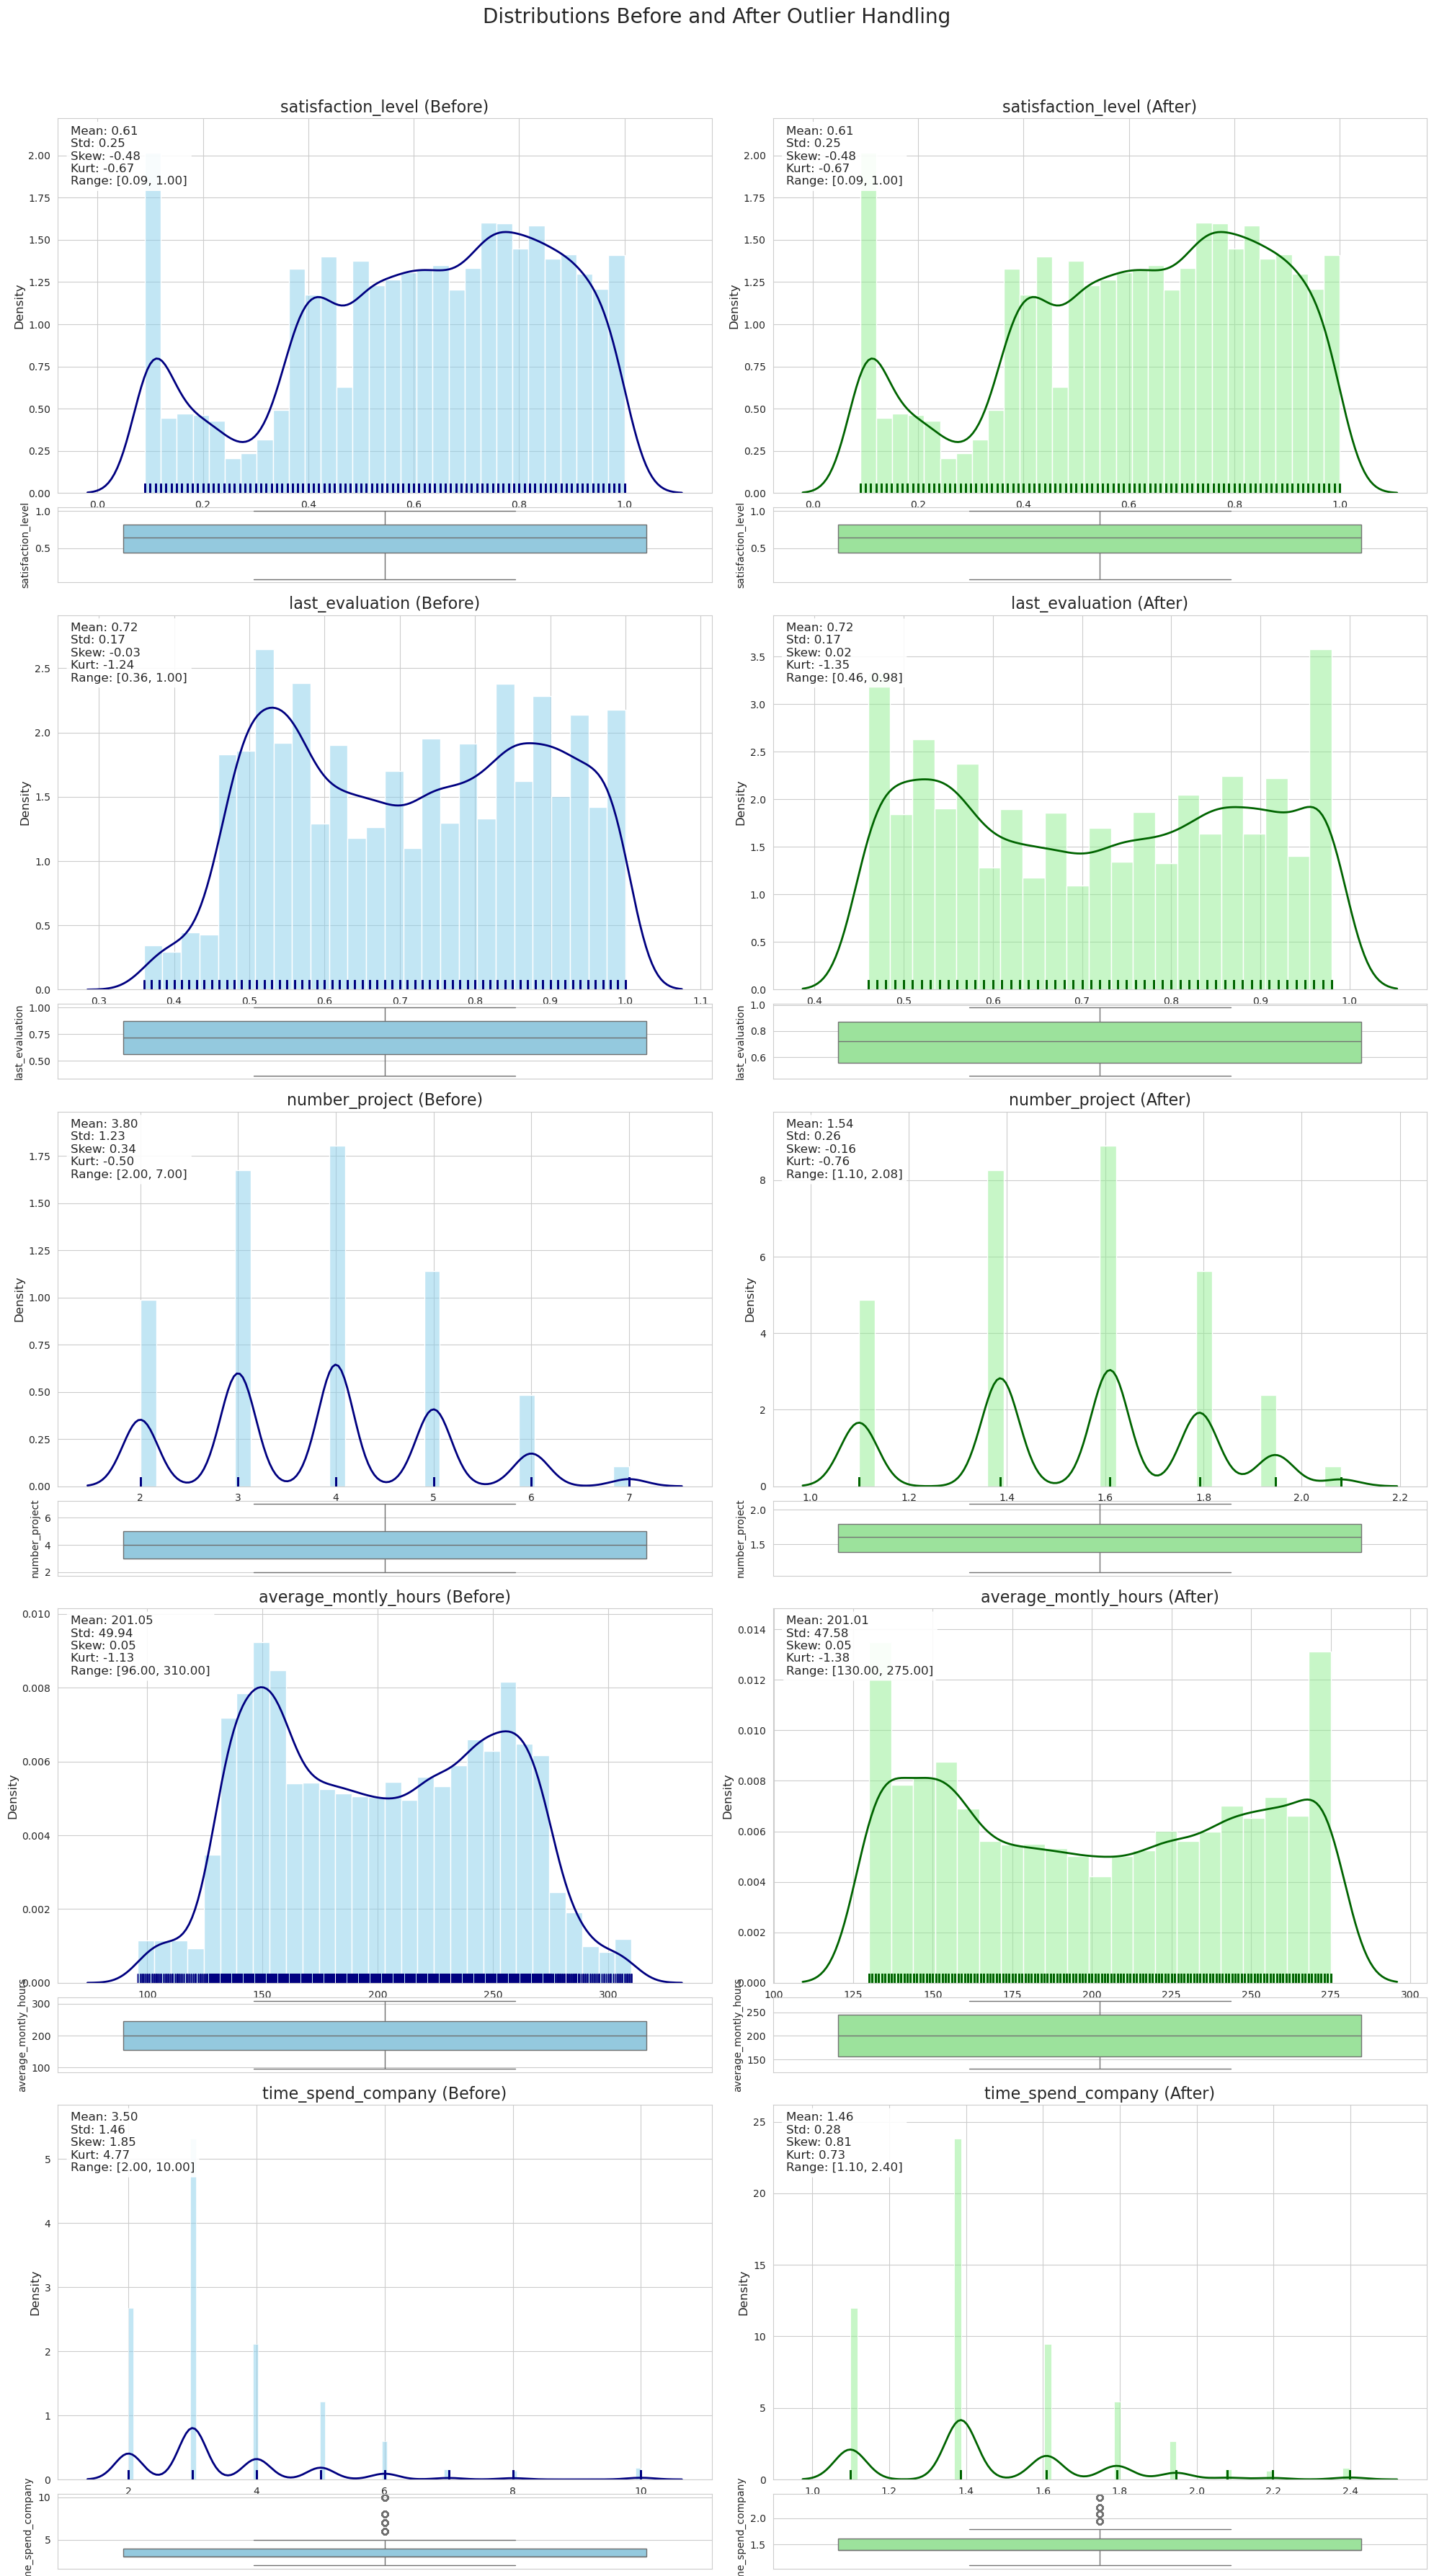


Detailed Summary of Changes:
--------------------------------------------------------------------------------

SATISFACTION_LEVEL:
----------------------------------------
Metric                Before        After       Change
----------------------------------------
Mean                   0.613        0.613        0.000
Std Dev                0.249        0.249        0.000
Skewness              -0.476       -0.476        0.000
Kurtosis              -0.671       -0.671        0.000
Min                    0.090        0.090        0.000
Max                    1.000        1.000        0.000

LAST_EVALUATION:
----------------------------------------
Metric                Before        After       Change
----------------------------------------
Mean                   0.716        0.717        0.001
Std Dev                0.171        0.167       -0.004
Skewness              -0.027        0.020        0.046
Kurtosis              -1.239       -1.350       -0.111
Min                    0.3

In [91]:
def plot_outlier_handling_results(df):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    
    df_processed = handle_outliers(df.copy())
    
    columns = ['satisfaction_level', 'last_evaluation', 'number_project',
              'average_montly_hours', 'time_spend_company']
    
    fig, axes = plt.subplots(len(columns), 2, figsize=(20, 7*len(columns)))
    fig.suptitle('Distributions Before and After Outlier Handling', fontsize=20, y=1.02)
    
    sns.set_style("whitegrid")
    
    for idx, column in enumerate(columns):
        sns.histplot(data=df[column], ax=axes[idx, 0], stat='density', 
                    color='skyblue', alpha=0.5)
        sns.kdeplot(data=df[column], ax=axes[idx, 0], color='navy', linewidth=2)
        sns.rugplot(data=df[column], ax=axes[idx, 0], color='navy', alpha=0.5)
        
        sns.histplot(data=df_processed[column], ax=axes[idx, 1], stat='density',
                    color='lightgreen', alpha=0.5)
        sns.kdeplot(data=df_processed[column], ax=axes[idx, 1], color='darkgreen', linewidth=2)
        sns.rugplot(data=df_processed[column], ax=axes[idx, 1], color='darkgreen', alpha=0.5)
        
        axes[idx, 0].set_title(f'{column} (Before)', fontsize=16)
        axes[idx, 1].set_title(f'{column} (After)', fontsize=16)
        
        stats_before = (f'Mean: {df[column].mean():.2f}\n'
                       f'Std: {df[column].std():.2f}\n'
                       f'Skew: {df[column].skew():.2f}\n'
                       f'Kurt: {df[column].kurtosis():.2f}\n'
                       f'Range: [{df[column].min():.2f}, {df[column].max():.2f}]')
        
        stats_after = (f'Mean: {df_processed[column].mean():.2f}\n'
                      f'Std: {df_processed[column].std():.2f}\n'
                      f'Skew: {df_processed[column].skew():.2f}\n'
                      f'Kurt: {df_processed[column].kurtosis():.2f}\n'
                      f'Range: [{df_processed[column].min():.2f}, {df_processed[column].max():.2f}]')
        
        axes[idx, 0].text(0.02, 0.98, stats_before, 
                         transform=axes[idx, 0].transAxes,
                         verticalalignment='top',
                         fontsize=12,
                         bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
        
        axes[idx, 1].text(0.02, 0.98, stats_after,
                         transform=axes[idx, 1].transAxes,
                         verticalalignment='top',
                         fontsize=12,
                         bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
        
        for ax in [axes[idx, 0], axes[idx, 1]]:
            ax.set_xlabel('Value', fontsize=12)
            ax.set_ylabel('Density', fontsize=12)
            ax.tick_params(labelsize=10)
            
        divider_left = make_axes_locatable(axes[idx, 0])
        divider_right = make_axes_locatable(axes[idx, 1])
        
        ax_box_left = divider_left.append_axes("bottom", size="20%", pad=0.2)
        ax_box_right = divider_right.append_axes("bottom", size="20%", pad=0.2)
        
        sns.boxplot(data=df[column], ax=ax_box_left, color='skyblue')
        sns.boxplot(data=df_processed[column], ax=ax_box_right, color='lightgreen')
        
        ax_box_left.set_xlabel('')
        ax_box_right.set_xlabel('')
    
    plt.tight_layout()
    plt.show()
    
    print("\nDetailed Summary of Changes:")
    print("-" * 80)
    for column in columns:
        print(f"\n{column.upper()}:")
        print("-" * 40)
        print(f"{'Metric':<15} {'Before':>12} {'After':>12} {'Change':>12}")
        print("-" * 40)
        
        metrics = {
            'Mean': (df[column].mean(), df_processed[column].mean()),
            'Std Dev': (df[column].std(), df_processed[column].std()),
            'Skewness': (df[column].skew(), df_processed[column].skew()),
            'Kurtosis': (df[column].kurtosis(), df_processed[column].kurtosis()),
            'Min': (df[column].min(), df_processed[column].min()),
            'Max': (df[column].max(), df_processed[column].max())
        }
        
        for metric, (before, after) in metrics.items():
            change = after - before
            print(f"{metric:<15} {before:>12.3f} {after:>12.3f} {change:>12.3f}")

from mpl_toolkits.axes_grid1 import make_axes_locatable

plot_outlier_handling_results(df)

In [93]:
def encode_categorical_variables(df):
    encoders = {}
   
    available_categorical_columns = [col for col in ['department', 'salary'] 
                                  if col in df.columns]
    
    for column in available_categorical_columns:
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        encoders[column] = le
    
    return df, encoders

In [102]:
def scale_features(df):
    df = df.copy()
    
    numeric_columns = ['satisfaction_level', 'last_evaluation', 'number_project',
                      'average_montly_hours', 'time_spend_company']
    
    
    df = handle_outliers(df)
    
    
    standard_scaler = StandardScaler()
    minmax_scaler = MinMaxScaler()
    
    
    df_standard = df.copy()
    df_minmax = df.copy()
    
    
    
    df_standard[numeric_columns] = standard_scaler.fit_transform(df[numeric_columns])
    
    
    df_minmax[numeric_columns] = minmax_scaler.fit_transform(df[numeric_columns])
    
    
    transformations = {
        'satisfaction_level': 'MAD + Scaling',
        'last_evaluation': 'Winsorization + Scaling',
        'number_project': 'Log + Scaling',
        'average_montly_hours': 'Winsorization + Scaling',
        'time_spend_company': 'Log + Scaling'
    }
    
    print("\nTransformations applied to each feature:")
    for feature, transform in transformations.items():
        print(f"{feature}: {transform}")
    
    return df_standard, df_minmax, standard_scaler, minmax_scaler


Transformations applied to each feature:
satisfaction_level: MAD + Scaling
last_evaluation: Winsorization + Scaling
number_project: Log + Scaling
average_montly_hours: Winsorization + Scaling
time_spend_company: Log + Scaling


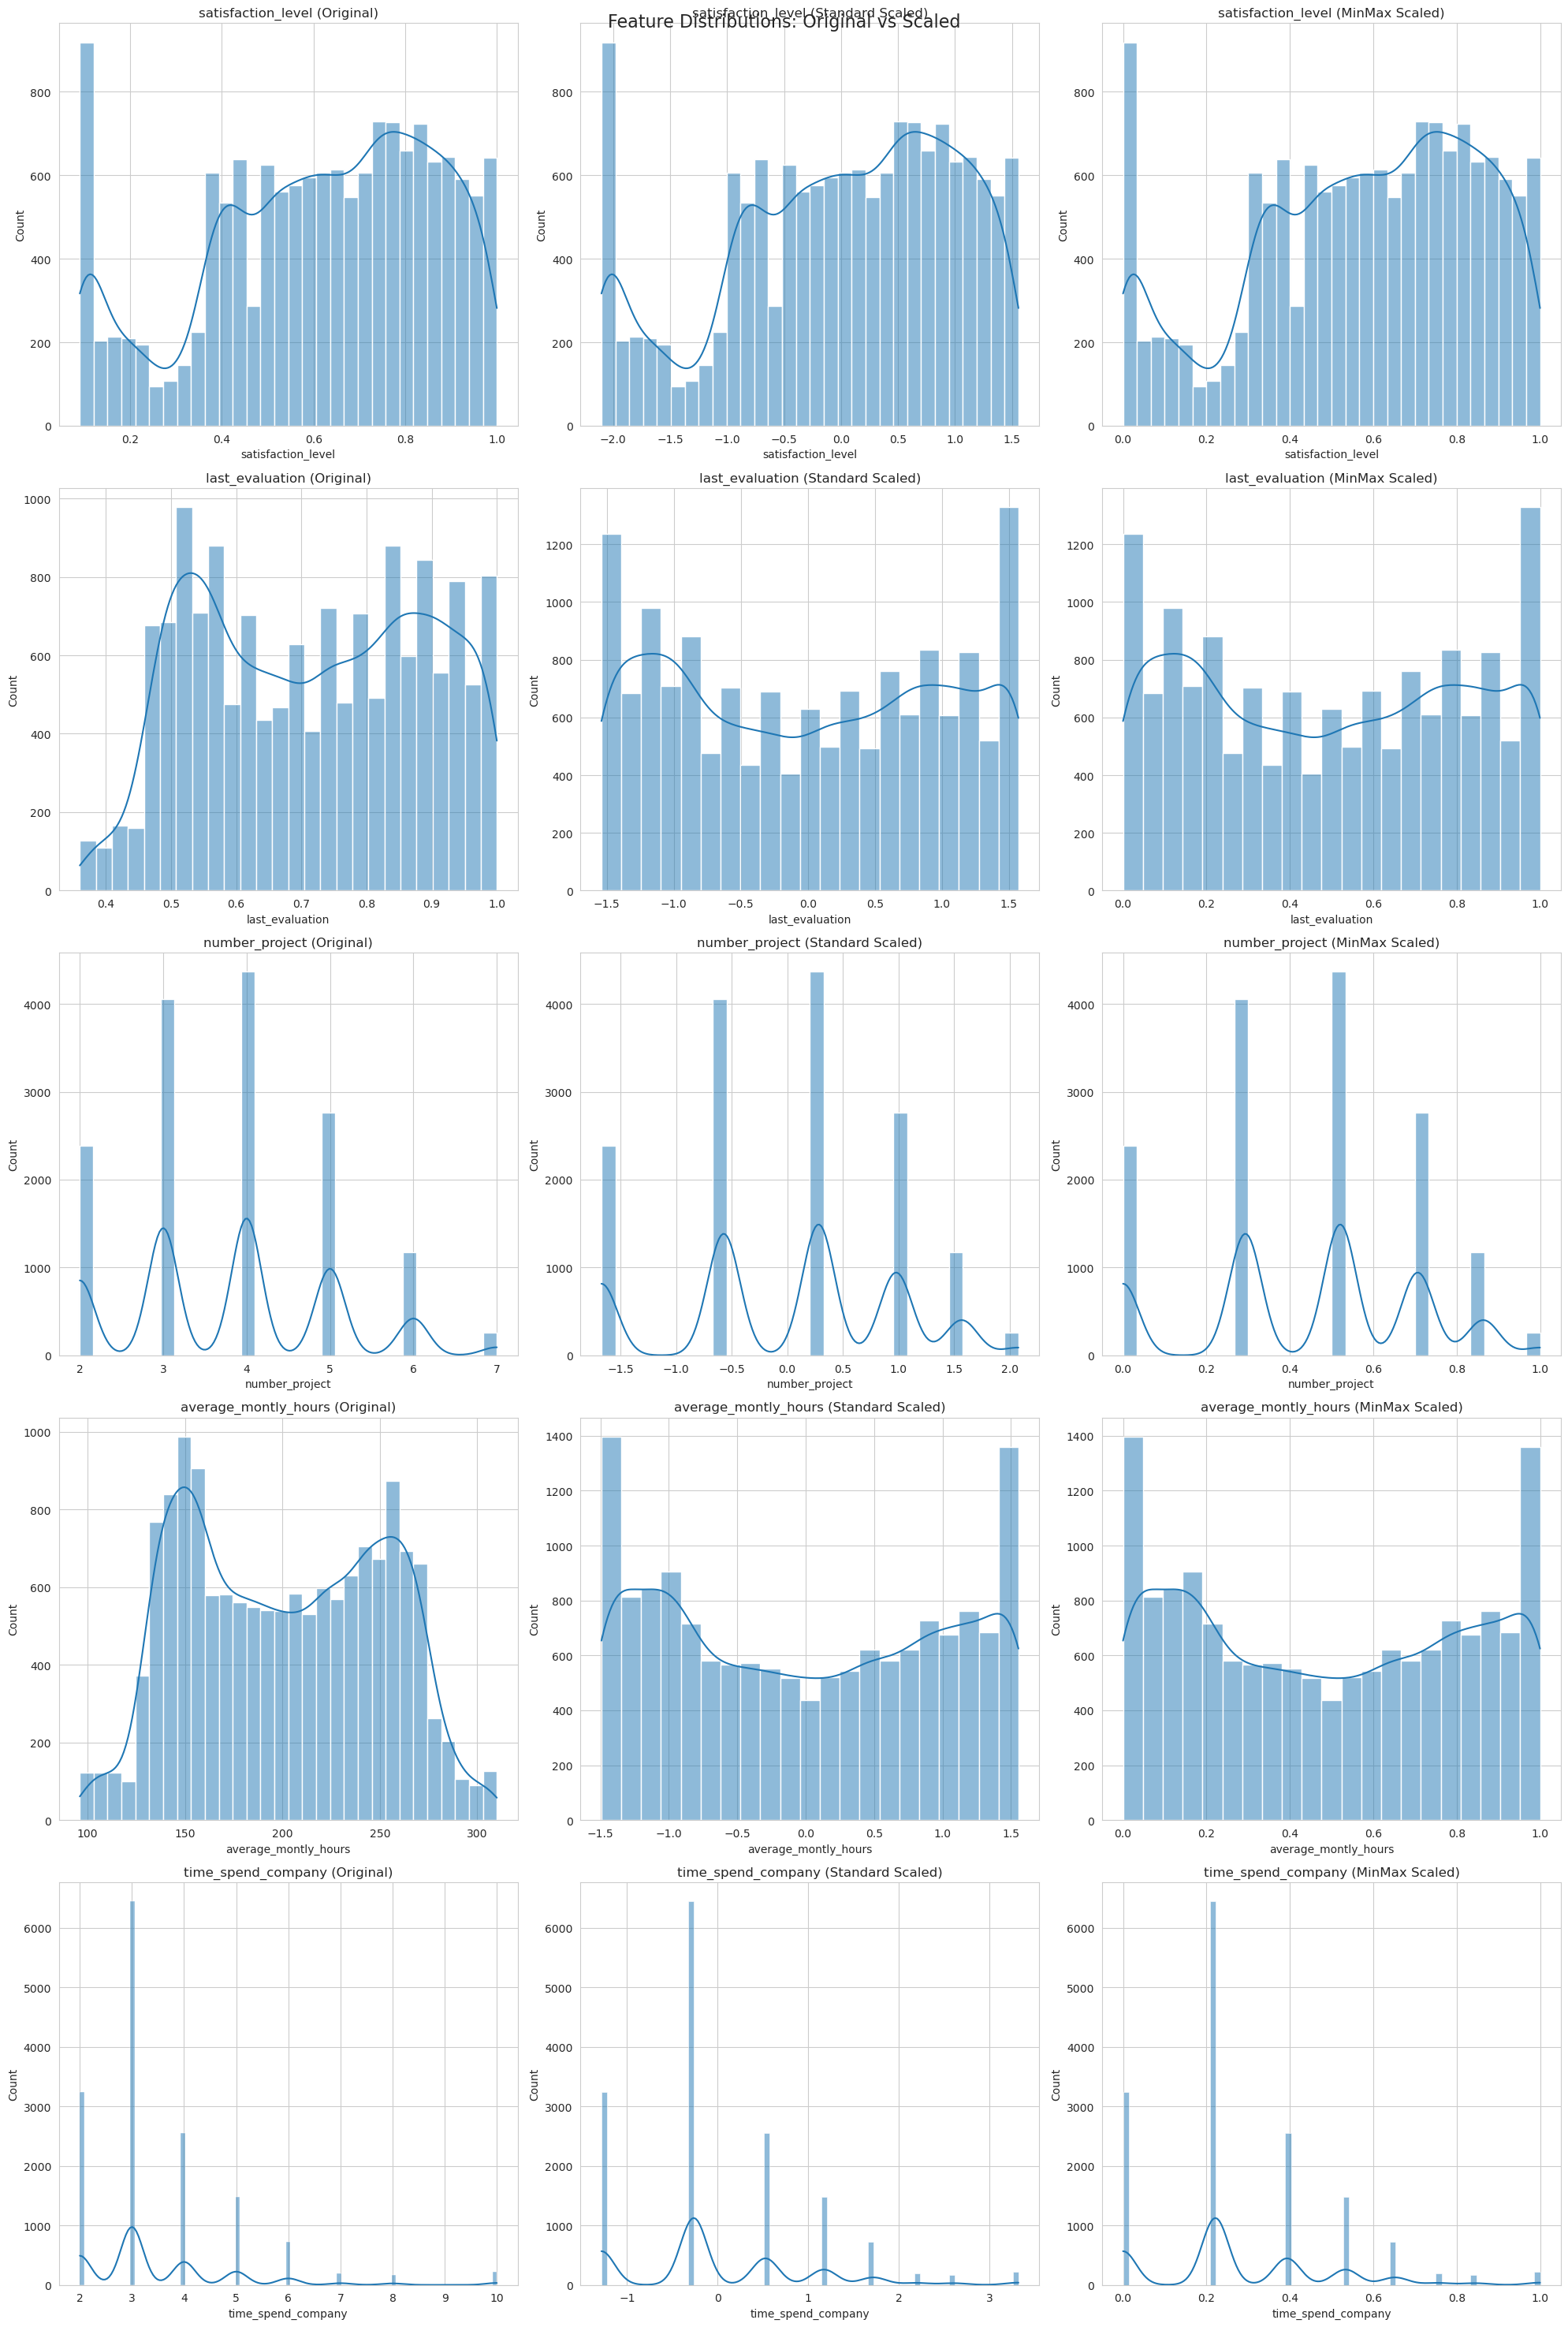

In [103]:

df_standard, df_minmax, standard_scaler, minmax_scaler = scale_features(df)


def plot_final_distributions(original_df, standard_df, minmax_df):
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    numeric_columns = ['satisfaction_level', 'last_evaluation', 'number_project',
                      'average_montly_hours', 'time_spend_company']
    
    fig, axes = plt.subplots(len(numeric_columns), 3, figsize=(20, 6*len(numeric_columns)))
    fig.suptitle('Feature Distributions: Original vs Scaled', fontsize=16)
    
    for idx, column in enumerate(numeric_columns):
        
        sns.histplot(data=original_df[column], ax=axes[idx, 0], kde=True)
        axes[idx, 0].set_title(f'{column} (Original)')
        
        
        sns.histplot(data=df_standard[column], ax=axes[idx, 1], kde=True)
        axes[idx, 1].set_title(f'{column} (Standard Scaled)')
        
        
        sns.histplot(data=df_minmax[column], ax=axes[idx, 2], kde=True)
        axes[idx, 2].set_title(f'{column} (MinMax Scaled)')
    
    plt.tight_layout()
    plt.show()


plot_final_distributions(df, df_standard, df_minmax)

In [104]:
def create_features(df):
    df['work_intensity'] = df['average_montly_hours'] / df['number_project']
    df['satisfaction_evaluation_ratio'] = df['satisfaction_level'] / df['last_evaluation']
    df['projects_per_year'] = df['number_project'] / df['time_spend_company']
    
    return df

In [105]:
def prepare_supervised_data(df_standard, test_size=0.2, random_state=42):
    X = df_standard.drop('left', axis=1)
    y = df_standard['left']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    return X_train, X_test, y_train, y_test

In [106]:

def prepare_clustering_data(df_minmax):
    clustering_data = df_minmax.drop('left', axis=1)
    original_labels = df_minmax['left']
    
    return clustering_data, original_labels

In [107]:
def main():
    df = load_data()
    df = handle_missing_values(df)
    df = handle_outliers(df)
    df, encoders = encode_categorical_variables(df)
    df = create_features(df)
    df_standard, df_minmax, standard_scaler, minmax_scaler = scale_features(df)
    X_train, X_test, y_train, y_test = prepare_supervised_data(df_standard)
    clustering_data, original_labels = prepare_clustering_data(df_minmax)
    
    preprocessed_data = {
        'supervised': {
            'X_train': X_train,
            'X_test': X_test,
            'y_train': y_train,
            'y_test': y_test
        },
        'clustering': {
            'data': clustering_data,
            'original_labels': original_labels
        },
        'transformers': {
            'encoders': encoders,
            'standard_scaler': standard_scaler,
            'minmax_scaler': minmax_scaler
        }
    }
    
    import pickle
    with open('preprocessed_hr_data.pkl', 'wb') as f:
        pickle.dump(preprocessed_data, f)
    
    return preprocessed_data

In [108]:
if __name__ == "__main__":
    preprocessed_data = main()


Transformations applied to each feature:
satisfaction_level: MAD + Scaling
last_evaluation: Winsorization + Scaling
number_project: Log + Scaling
average_montly_hours: Winsorization + Scaling
time_spend_company: Log + Scaling
